# Get the data

We will work with the MNIST dataset. (Y. LeCunn)
This set contains a lot of digits handwritten, and we will use classification algorithm on it.

In [2]:
import time

start = time.time()
# INSTRUCTION 
stop = time.time()
print('Take {}s seconds'.format(stop-start))

Take 0.0s seconds


In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml("mnist_784",version=1)

In [4]:
 mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [7]:
X, y = mnist['data'],mnist['target']
print(X.shape)
print(y.shape)

# y elements are string, in fact we could change them into an int (since it's number)
y = y.astype(np.uint8)




(70000, 784)
(70000,)


We have 70,000 images with 784 features each pictures ! 
An for y.shape we have the target (labels) values. 

In fact one picture is 28x28 pixels (from 0(white) to 255(black) ) so we get: 28x28=784 features. We can try to plot them here.

In [8]:
X_train,y_train,X_test,y_test = X[:60000],y[:60000],X[60000:],y[60000:]

The dataset is already splited into two parts : the first 60,000 elements are the train set and the other 10,000 the test set.

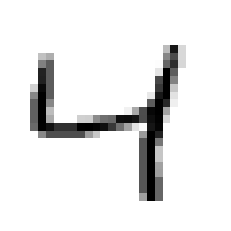

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt 

some_digit=X[2]
some_digit_image = some_digit.reshape(28,28) # Reshape to get the image matrix !

plt.imshow(some_digit_image,cmap='binary')
plt.axis("off")
plt.show()

## Training a Binary Classifer (SGD)

Binary classifier, capable of distinguishing between just two classes (e.g.3 and not 3)

In [6]:
#To find all the 3 digits ! 
np.where(y_train == 3)

(array([    7,    10,    12, ..., 59978, 59980, 59996], dtype=int64),)

In [7]:
# We take the correct labels ! 
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)

## SGD Classifier

In [8]:
# Here we will use a Stochastic Gradient Descent classifier (SGD)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)

sgd_clf.fit(X_train,y_train_3)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
# Test the prediction on X[10,7] (y[10] & y[7] is in class "3")
sgd_clf.predict([X[10],X[7]])

array([ True, False])

We can see that the result is not verry good for X[7], let's look at the picture ! 

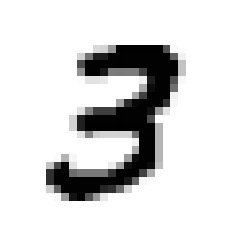

In [10]:
plt.imshow(X[7].reshape(28,28),cmap='binary')
plt.axis("off")
plt.show()

It's look like our prediction is not quite good, in fact we have a "3" digit, but our model return false. 
We can check this performance ! 

### Performance Measure

Compare to a regressor, when we computed the performance with the RMSE. For the classification we have a lot of performance measure (and it's trickier than regressor !)

#### Measuring Accuracy Using Cross Validation

Accuracy for ratio of correct predictions

In [14]:
from sklearn.model_selection import cross_val_score

#cross_val_score(sgd_clf,X_train,y_train_3,cv=3,scoring='accuracy')

We have good performance ! 

But in fact we have only 10% of our images correspond to 5. And if we guess that an image is not 5 we will be right about 90% of the time !

#### Confusion Matrix

Count the number of times instances of class A are classified as class B. 
Check the intersection between the row in class A and the column in class B

In [12]:
# We need to have a set of predictions to compare with target values  

from sklearn.model_selection import cross_val_predict

y_train_3_pred = cross_val_predict(sgd_clf,X_train,y_train_3,cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_3,y_train_3_pred)

# Each row represents an actual class , columns predictor class. 
# First row consider non-3 class : 53,477 correctly classified (true negatives), and 392 wrongly classified (false positives)
# Second row consider class of image 3 : 2113 wrongly classified (false negative), 4018 correctly classified (true positives)
# TN | FP
# FN | TP

# A perfect classifier would have only true positives ans true negatives.


We ca use a better mettric : Precision of the classifier = (True Positives) / (True Positives + False Positives) Compute the accuracy of the positive predictions. 


We also use recall = (True Positives) / (True Positives + False Negatives)
Called the sensitivity or the true positive rate (TPR). 
Compute the ratio of positive instances that are correctly detected by classifier. 

In [14]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_3,y_train_3_pred))

print(recall_score(y_train_3,y_train_3_pred))

0.9111111111111111
0.655358016636764


We have 91% of chances that a 3 is a "real" 3 ! 
But only detect 65,5% of all of 3 !!

To complete the analysis, wa can check the harmonic mean F1. 
The harmonic mean gives more weight to low values (compared to regular mean who treats each values equally). But not necessary in all cases. 


##### Precision/Recall Trade-off
Unfortunately, we can't have both ways: increasing precission reduces recall, and vice versa. This is the Precision/Recall Trade-off (we can tune this trade-off, by modifying a treshold (default value is 0). Instead of making direct prediction, we use a decision_function to compute a score, then use the threshold to check if it's a good prediction or not. 

In [15]:
y_score = sgd_clf.decision_function([X[10]])
threshold =0
y_digit10_prediction = (y_score > threshold)
y_digit10_prediction

# We increase teshold -> More precision but less recall 



array([ True])

If we want to choose the correct threshold value, we can plot a precision and recall function (precision_recall_curve on the scores we get from a previous cross_validation with decision_function parameter instead of predictions) 

In [19]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_3,cv=3,method="decision_function")

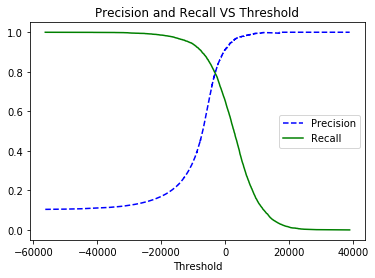

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve (y_train_3, y_scores)

def plot_precision_recall_VS_threshold(precisions, recalls, thresholds):
    # %matplotlib notebook
    plt.plot(thresholds, precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds, recalls[:-1],'g-',label='Recall')
    plt.xlabel('Threshold')
    plt.title("Precision and Recall VS Threshold")
    plt.legend()
    plt.show()

    
plot_precision_recall_VS_threshold(precisions,recalls,thresholds)
    

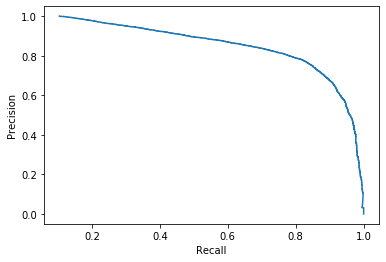

In [23]:
plt.plot(precisions,recalls)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

Imagine we want a precision arroud 90%. We can fine tune this, and find the lowest trhresholds that gives us at least 90% of precision


In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

# To make our prediction we can use this : 
y_train_pred_90 = (y_scores >= threshold_90_precision)

print(precision_score(y_train_3,y_train_pred_90))
print(recall_score(y_train_3,y_train_pred_90))

0.9000870700914236
0.6744413635622247


##### The ROC Curve

The receiver operating characteristic (ROC), plots the true positive rate (TPR)(Recall) against the false positive rate (FPR). 

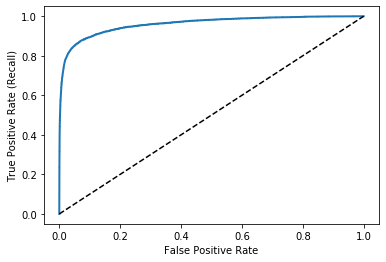

In [25]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_3,y_scores)

def plot_roc_curve(fpr,tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--') # dashed diagonal
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel('False Positive Rate')
    plt.show()
    
plot_roc_curve(fpr,tpr)

We can compare classifiers with the area under the curve (AUC)

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_3,y_scores)

0.9599243001892759

We have good result, but the Precision/Recall curve is not at the top right, which means we can improve our model.

## RandomForestClassifier

To get scores from this, we have to used predict_proba instead of (decision_function).

Predict_proba : return an array containing a row per instance and a column per class, each containing the probability that the given instance belongs to the given class. 

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
                                    
y_proba_forest = cross_val_predict(forest_clf,X_train,y_train_3, 
                                   cv=3, method='predict_proba')

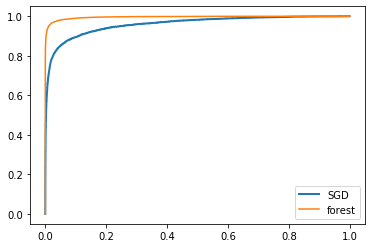

In [28]:
y_scores_forest = y_proba_forest[:,1]

fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_3,y_scores_forest)

plt.plot(fpr,tpr, linewidth=2,label='SGD')
plt.plot(fpr_forest,tpr_forest,label='forest')
plt.legend()



In [29]:
roc_auc_score(y_train_3,y_scores_forest)

0.995864544068936

We can try to compute the precision and the recall for this ML algo. 

In [38]:
y_forest_predict = cross_val_predict(forest_clf,X_train,y_train_3,cv=3)

In [40]:
print(precision_score(y_train_3,y_forest_predict))
print(recall_score(y_train_3,y_forest_predict))

0.9947481034818129
0.8341216767248409


We have a precision about 99,47% and a recall about 83,41%. 

83% of the 3's are detected (miss some values) and we are sure about 99,47% that a detection is really a good one (a 3 image is a 3)

# Multiclass Classification

Such as Random Forest Regression classifiers, Logistic Regression classifiers, Naives Bayes classifiers. 

SGD and Support Vector Machine classifiers are strictly binary classifiers.

In fact we have two strategys : 

**OvR : One vs the Rest :** create as much as binary classifier as you have classes. Then when you want to classify an instance, you put it through the entire classifiers. The best score gives you the class of the instance. 

**OvO : One vs One:** Train a binary classifier for every pair of classes. If you have N classes, you train N * (N-1)/2 classifiers. 

Scikit-Learn detects when we want to make a multiclass classification task and choose automatically OvO or OvR. Or you can force it with the sklearn.multiclass (OneVSRestClassifier) or (OneVSOneLcassifier) and put the classifier you want in the constructor of the multiclass. (e.g. OneVsRest(SVC()) )

Let's try this with SVM classifier.

### SVM Classifier 

In [18]:
from sklearn.svm import SVC


start = time.time()

svm_clf = SVC(C=5,loss='hinge',max_iter=10000)
svm_clf.fit(X_train,y_train)

stop = time.time()
print('Take {}s seconds'.format(stop-start))

Take 443.9266140460968s seconds


In [19]:
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


Take 443.93s seconds. Wether 7m minutes and 23.93s seconds


In [22]:
X_train_scaled = StandardScaler().fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
start = time.time()

cross_val_score(svm_clf,X_train_scaled,y_train,cv=10,scoring='accuracy')

stop = time.time()
print('Redo the cross validation\n')
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


In [ ]:
svm_clf.predict([X[10]]) # Must detect 3

In [45]:
#We can also see the list of classes: 
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [53]:
#We can see with the decision function the score for each classes 
resul_x10 = svm_clf.decision_function([X[10]])

#Then we see that the 4th element has the best score, so X[10] is a class of the 4th element (class 3)
index_max = np.argmax(resul_x10)

print("X[10] is a class ",svm_clf.classes_[index_max])

X[10] is a class  3


### SGD Classifier (Multiclass)

In [54]:
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [64]:
print("Classes:",sgd_clf.classes_,"\n")
print("Score for X[10]:\n",sgd_clf.decision_function([X[10]]),"\n")
print("Score for X[1]:\n",sgd_clf.decision_function([X[0]]),"\n")

Classes: [0 1 2 3 4 5 6 7 8 9] 

Score for X[10]:
 [[-32927.58071595 -17846.08012197  -9117.15524931   8110.41175195
  -20824.50629491  -7276.9608832  -23298.24023431 -21227.32271866
   -3488.10980768  -5439.38177054]] 

Score for X[1]:
 [[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]] 



We can evaluate the model with cross validation:

In [103]:
start = time.time()
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')
stop = time.time()
print('Cross_validation for sgd_clf on all the training set\n')
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


Cross_validation for sgd_clf on all the training set

Take 250.02768993377686s seconds


In [116]:
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


Take 250.03s seconds. Wether 4m minutes and 10.03s seconds


In [11]:
# We can try to improve our scoring with scaling the input. 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

start = time.time()

X_train_scaled = scaler.fit_transform(X_train)

stop = time.time()
print('Scaled the X_train set\n')
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))




start = time.time()

cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

stop = time.time()
print('Redo the cross validation\n')
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))




Scaled the X_train set

Take 0.99s seconds. Wether 0m minutes and 0.99s seconds


NameError: name 'cross_val_score' is not defined

Take 641.37s seconds. Wether 10m minutes and 41.37s seconds


# Error Analysis 

In a real ML project, we have to follow the data preparation, try multiple models, fine tuning the models ans automate as much as possible. 

When we found our model, we want to improve it: by analysing the errors it makes for example. 


In [124]:
# Check the confusion matrix 
start=time.time()
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
stop = time.time()
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


Take 641.42s seconds. Wether 10m minutes and 41.42s seconds


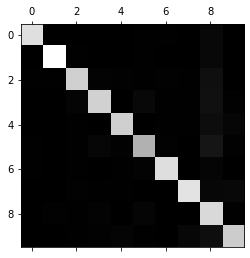

In [126]:
conf_mx = confusion_matrix(y_train,y_train_pred)

plt.matshow(conf_mx,cmap=plt.cm.gray)

We can see that it seems pretty good (diagonal is bright, means each class is correctly predictable). 
We can check the errors. We will divide each value by the number of images in the corresponding classes, we will then compare each error rate.

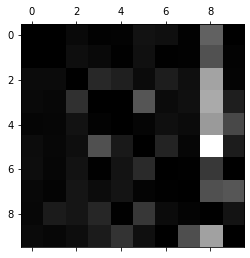

In [133]:
row_sum = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sum

# Fill the diagonal with zeros, to get only errors. 
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

We can see that some 8 are classified as 5 or 2. 

We could improve our model with more data of 8 (which is not 8) to train it to detect false 8.

# Multilable classification 

For example on a picture, you see 3 faces, you have to add a label for the three faces. 

In [136]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 ==1)
y_multilabel = np.c_[y_train_large,y_train_odd]
# We created a multilabel array. A predict would return True or False corresponding to the label.  

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [139]:
knn_clf.predict([X[0]]) # It's nots large (5<7) and it's odd.

array([[False,  True]])

# Multioutput Classification

Each label could be multiclass

# Exercices

## Try to build a classifier for the MNIST dataset that achieve over 97% accuracy on the test set. 

Hint: KNeighborsClassifier, find good hyperparamet values (weights and n_neighbors) 

### Test with the svm classifier

In [156]:
y_test_predict = svm_clf.predict(X_test)

In [172]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test,y_test_predict)

0.9792

### Test with the forest classifier

In [173]:
start = time.time()
forest_clf.fit(X_train_scaled,y_train)
stop=time.time()
print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


Take 42.81s seconds. Wether 0m minutes and 42.81s seconds


In [174]:
y_test_predict_forest = forest_clf.predict(X_test)

In [1]:
accuracy_score(y_test,y_test_predict_forest)

NameError: name 'accuracy_score' is not defined

### Test with the KNneighbors Classifier

We have to search for the correct and best hyperparameter. But First try with the basic parameter. 

start=time.time()
print(cross_val_score(knn_clf,X_train,y_train,cv=3,scoring='accuracy'))
stop=time.time()

print('Take {:.2f}s seconds. Wether {:.0f}m minutes and {:.2f}s seconds'.format(stop-start,np.floor((stop-start)/60),(stop-start)%60))


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Here we define a list of dictionaries with 'parameter':[values to test]
# Each parameter will be used, so it should corresponds to the ML algo parameters
param_grid = [
    {'weights':[3,10,30],'n_neighbors':[2,3,4]},
]

new_KNC = KNeighborsClassifier()

grid_search_KNC = GridSearchCV(new_KNC,param_grid,cv=3,
                                 scoring='accuracy', 
                                  return_train_score=True)

# We can train our model with multiple parameters
#grid_search_KNC.fit(X_train,y_train)

## Build a spam classifier